# Gentrification Degree Index (GDI) for Paris, 2013–2021

**Scope:** Clean, minimal, reproducible GDI for Paris quartiers (Habitation only), 2013–2017–2021.

**Data sources:**
- `paris_merged_2013.parquet`, `paris_merged_2017.parquet`, `paris_merged_2021.parquet`: Neighborhood-level indicators
- `quartiers_paris.geojson`: Spatial geometries with type_quartier classification

**Six indicators** (pooled z-scores, equal weights):
- median_uc (+), prix_m2_median (+), pct_cadres (+), pct_ouvriers (−), pct_bac_sup (+), pct_25_39 (+)

**Spatial scope:** Analysis on 71 Habitation quartiers. Activité and Divers shown as hatched background on maps only.

## 1. Imports and Setup

In [2]:
import os
import warnings
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, ttest_rel
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

# Suppress specific warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in divide')
warnings.filterwarnings('ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

DATA_DIR = '../datasets'
GEO_FILE = f'{DATA_DIR}/quartiers_paris.geojson'

# Create output directories
os.makedirs('./_artifacts/figures/maps', exist_ok=True)
os.makedirs('./_artifacts/figures/plots', exist_ok=True)
os.makedirs('./_artifacts/tables', exist_ok=True)

print('Setup complete. Output directories created.')

Setup complete. Output directories created.


/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data and Filter to Habitation Quartiers

In [3]:
# Load three waves
files = ['paris_merged_2013.parquet', 'paris_merged_2017.parquet', 'paris_merged_2021.parquet']
dfs = []
for f in files:
    df_temp = pd.read_parquet(f'{DATA_DIR}/{f}')
    df_temp.columns = df_temp.columns.str.lower()
    year = int(f.split('_')[-1].replace('.parquet', ''))
    df_temp['annee'] = year
    dfs.append(df_temp)
    print(f'Loaded {f}: {len(df_temp)} rows')

df = pd.concat(dfs, ignore_index=True)

# Filter to Habitation only
df = df[df['type_neighborhood'].eq('Habitation')].copy()
print(f'\nFiltered to Habitation: {len(df)} rows')
print(f'Quartiers per year: {df.groupby("annee")["neighborhood"].nunique().to_dict()}')

Loaded paris_merged_2013.parquet: 71 rows
Loaded paris_merged_2017.parquet: 71 rows
Loaded paris_merged_2021.parquet: 71 rows

Filtered to Habitation: 213 rows
Quartiers per year: {2013: 71, 2017: 71, 2021: 71}


## 3. Derive Indicators and Year De-Trend

In [4]:
# Rename key columns for clarity
df = df.rename(columns={'neighborhood': 'quartier'})

# Derive pct_bac_sup
df['pct_bac_sup'] = 100 * df['pop_bac_sup'] / df['pop_15plus']

# Year de-trend for income and price
for v in ['median_uc', 'prix_m2_median']:
    df[f'{v}_detr'] = df[v] - df.groupby('annee')[v].transform('median')
    print(f'{v}_detr medians by year (should be near zero):')
    print(df.groupby('annee')[f'{v}_detr'].median())

print('\nDerived indicators created and de-trended.')

median_uc_detr medians by year (should be near zero):
annee
2013    0.0
2017    0.0
2021    0.0
Name: median_uc_detr, dtype: float64
prix_m2_median_detr medians by year (should be near zero):
annee
2013    0.0
2017    0.0
2021    0.0
Name: prix_m2_median_detr, dtype: float64

Derived indicators created and de-trended.


## 4. Pooled Winsorization and Standardization

In [5]:
# Winsor function
def winsor(s, p=0.025):
    return s.clip(s.quantile(p), s.quantile(1 - p))

# Six indicators with polarity
spec = [
    ('median_uc_detr', +1),
    ('prix_m2_median_detr', +1),
    ('pct_cadres', +1),
    ('pct_ouvriers', -1),
    ('pct_bac_sup', +1),
    ('pct_25_39', +1),
]

for col, sign in spec:
    x = winsor(df[col].astype(float))
    mu, sd = x.mean(), x.std(ddof=0)
    if sd == 0:
        df[f'z_{col}'] = 0.0
    else:
        df[f'z_{col}'] = sign * (x - mu) / sd
    print(f'{col:25s} | sign={sign:+2d} | μ={mu:10.2f}, σ={sd:8.2f}')

print('\nPooled z-scores computed.')

median_uc_detr            | sign=+1 | μ=    637.74, σ= 7128.72
prix_m2_median_detr       | sign=+1 | μ=    213.63, σ= 1644.07
pct_cadres                | sign=+1 | μ=     30.87, σ=    5.27
pct_ouvriers              | sign=-1 | μ=      3.86, σ=    1.76
pct_bac_sup               | sign=+1 | μ=     53.71, σ=    7.40
pct_25_39                 | sign=+1 | μ=     25.99, σ=    4.70

Pooled z-scores computed.


## 5. Composite GDI (Equal Weights, 0–100 Rescale)

In [6]:
zcols = [f'z_{c}' for c, _ in spec]
df['GDI_raw'] = df[zcols].mean(axis=1)

# Min-max rescale to [0, 100]
gmin, gmax = df['GDI_raw'].min(), df['GDI_raw'].max()
df['GDI'] = 100 * (df['GDI_raw'] - gmin) / (gmax - gmin)

print(f'GDI range: [{df["GDI"].min():.1f}, {df["GDI"].max():.1f}]')
print(f'Mean: {df["GDI"].mean():.1f}, Median: {df["GDI"].median():.1f}')

GDI range: [0.0, 100.0]
Mean: 65.9, Median: 73.5


In [7]:
# Save tidy panel
keep_cols = ['quartier', 'annee', 'median_uc', 'prix_m2_median', 'pct_cadres', 'pct_ouvriers', 
             'pct_bac_sup', 'pct_25_39', 'GDI'] + zcols
df[keep_cols].to_parquet('./_artifacts/GDI_panel.parquet', index=False)
print('Saved GDI_panel.parquet')

Saved GDI_panel.parquet


### 5.1 Indicator Contribution Analysis

Which indicators contribute most to the final GDI? We examine correlations between standardized indicators and the composite index.


Indicator contribution to GDI (2021):
z_pct_bac_sup            0.956
z_pct_ouvriers           0.867
z_pct_cadres             0.856
z_prix_m2_median_detr    0.748
z_median_uc_detr         0.739
z_pct_25_39              0.122
Name: GDI, dtype: float64


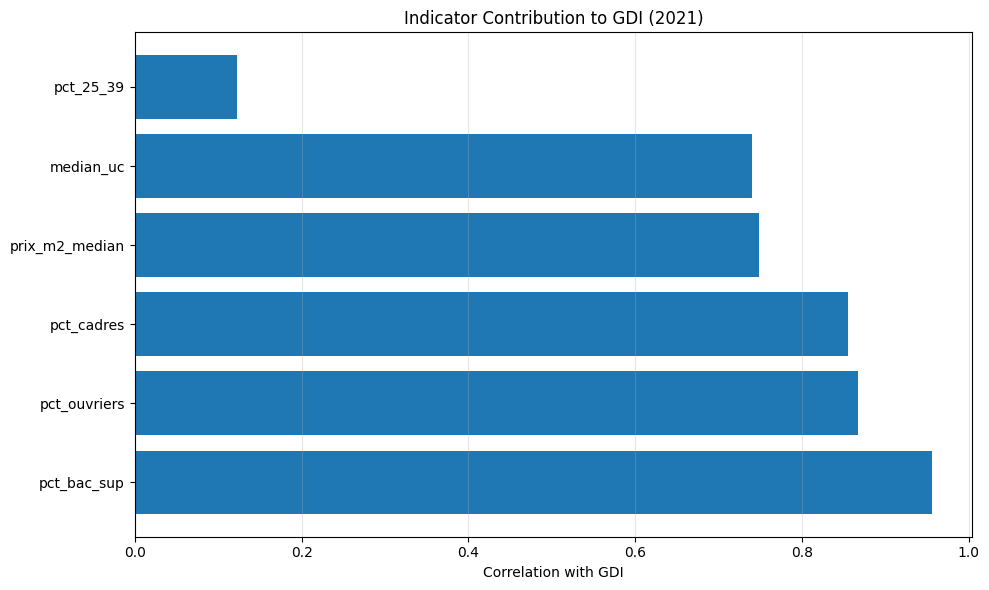


Saved indicator_contribution.png


In [8]:
# Calculate correlation of each z-score with final GDI (using 2021 data)
df_2021 = df[df['annee'] == 2021].copy()
contrib = df_2021[zcols + ['GDI']].corr()['GDI'].drop('GDI').sort_values(ascending=False)

print('\nIndicator contribution to GDI (2021):')
print(contrib)

# Bar chart
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
indicator_labels = [c.replace('z_', '').replace('_detr', '') for c in contrib.index]
ax.barh(indicator_labels, contrib.values)
ax.set_xlabel('Correlation with GDI')
ax.set_title('Indicator Contribution to GDI (2021)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/indicator_contribution.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved indicator_contribution.png')

**Interpretation:** Higher correlation indicates stronger contribution to final GDI. Education and occupation indicators typically dominate the composite, reflecting their centrality in gentrification processes.

## 6. Temporal Change and Simple 3-Bin Classification

In [9]:
# Pivot to wide
wide = df.pivot_table(index='quartier', columns='annee', values='GDI')
wide = wide.rename(columns={2013: 'GDI_2013', 2017: 'GDI_2017', 2021: 'GDI_2021'})

# Compute changes
wide['d13_17'] = wide['GDI_2017'] - wide['GDI_2013']
wide['d17_21'] = wide['GDI_2021'] - wide['GDI_2017']
wide['d13_21'] = wide['GDI_2021'] - wide['GDI_2013']

# Calculate annual rates
wide['d13_17_rate'] = wide['d13_17'] / 4  # per year
wide['d17_21_rate'] = wide['d17_21'] / 4  # per year

# Simple 3-bin trajectory on d13_21
q25, q75 = wide['d13_21'].quantile([0.25, 0.75])
def lab(x):
    if x >= q75:
        return 'Accelerating/strong increase'
    if x <= q25:
        return 'Declining/weak'
    return 'Moderate/stable'

wide['trajectory'] = wide['d13_21'].apply(lab)

print(f'Change thresholds: Q25={q25:.2f}, Q75={q75:.2f}')
print('\nTrajectory distribution:')
print(wide['trajectory'].value_counts())

Change thresholds: Q25=1.83, Q75=11.29

Trajectory distribution:
trajectory
Moderate/stable                 35
Declining/weak                  18
Accelerating/strong increase    18
Name: count, dtype: int64


### 6.1 Period Comparison: Did gentrification accelerate or slow down?

Period comparison:
  2013-2017 mean rate: 1.187 GDI points/year
  2017-2021 mean rate: 0.697 GDI points/year

Paired t-test: t=2.457, p=0.0165
  → Rates differ significantly between periods


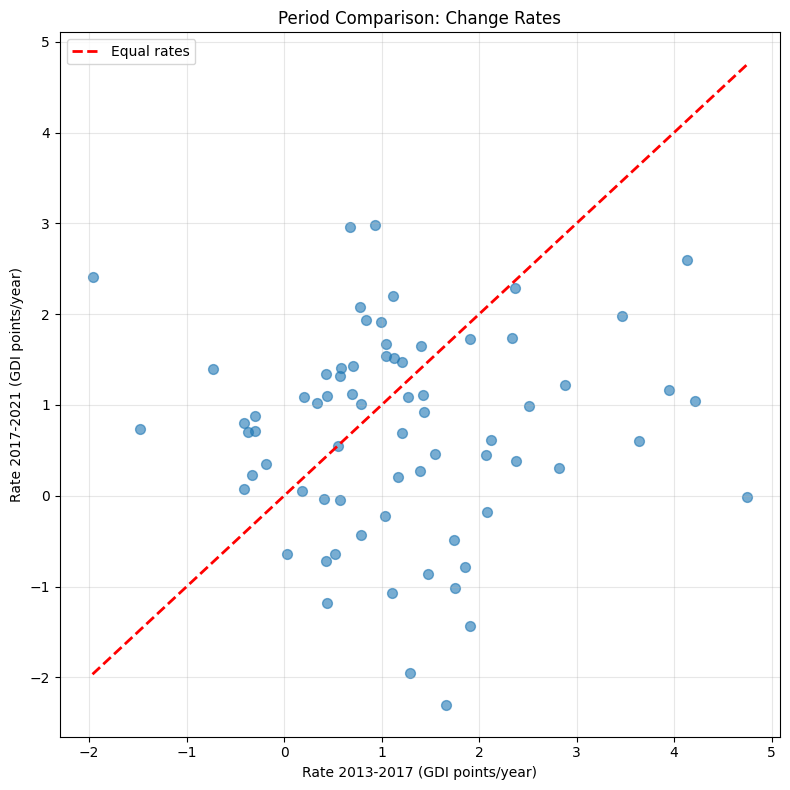


Saved period_comparison.png


In [10]:
# Test if change rates differ significantly between periods
t_stat, p_val = ttest_rel(wide['d13_17_rate'], wide['d17_21_rate'])

print('Period comparison:')
print(f'  2013-2017 mean rate: {wide["d13_17_rate"].mean():.3f} GDI points/year')
print(f'  2017-2021 mean rate: {wide["d17_21_rate"].mean():.3f} GDI points/year')
print(f'\nPaired t-test: t={t_stat:.3f}, p={p_val:.4f}')
if p_val < 0.05:
    print('  → Rates differ significantly between periods')
else:
    print('  → No significant difference in rates')

# Visualization: scatter plot comparing periods
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(wide['d13_17_rate'], wide['d17_21_rate'], alpha=0.6, s=50)
ax.plot([wide['d13_17_rate'].min(), wide['d13_17_rate'].max()],
        [wide['d13_17_rate'].min(), wide['d13_17_rate'].max()],
        'r--', linewidth=2, label='Equal rates')
ax.set_xlabel('Rate 2013-2017 (GDI points/year)')
ax.set_ylabel('Rate 2017-2021 (GDI points/year)')
ax.set_title('Period Comparison: Change Rates')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/period_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved period_comparison.png')

**Interpretation:** Points above the diagonal line indicate acceleration (faster gentrification in 2017-2021); below indicates deceleration.

### 6.2 Baseline-Change Regression Analysis

Baseline-change regression:
  Slope: -0.0744
  Intercept: 12.1371
  R²: 0.0705
  p-value: 0.0253

Interpretation: For every 10-point increase in baseline GDI,
                 change decreases by 0.74 points


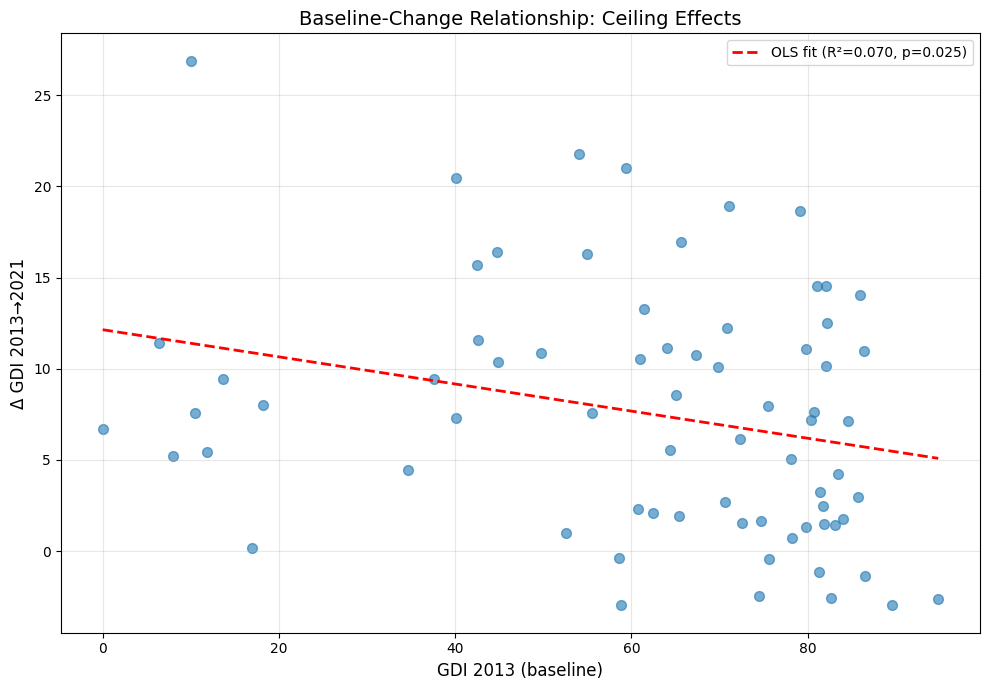


Saved baseline_vs_change.png


In [11]:
# Quantify baseline-change relationship
slope, intercept, r_val, p_val, std_err = linregress(wide['GDI_2013'], wide['d13_21'])

print('Baseline-change regression:')
print(f'  Slope: {slope:.4f}')
print(f'  Intercept: {intercept:.4f}')
print(f'  R²: {r_val**2:.4f}')
print(f'  p-value: {p_val:.4f}')
print(f'\nInterpretation: For every 10-point increase in baseline GDI,')
print(f'                 change decreases by {abs(slope*10):.2f} points')

# Enhanced scatter with R² annotation
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.scatter(wide['GDI_2013'], wide['d13_21'], alpha=0.6, s=50)
x_range = np.linspace(wide['GDI_2013'].min(), wide['GDI_2013'].max(), 100)
ax.plot(x_range, intercept + slope * x_range, 'r--', linewidth=2, 
        label=f'OLS fit (R²={r_val**2:.3f}, p={p_val:.3f})')
ax.set_xlabel('GDI 2013 (baseline)', fontsize=12)
ax.set_ylabel('Δ GDI 2013→2021', fontsize=12)
ax.set_title('Baseline-Change Relationship: Ceiling Effects', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/baseline_vs_change.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nSaved baseline_vs_change.png')

**Interpretation:** A negative slope suggests ceiling effects—neighborhoods with high baseline GDI have less room to grow. A positive slope would indicate divergence (rich get richer).

In [12]:
# Save wide table
wide.reset_index().to_parquet('./_artifacts/GDI_wide.parquet', index=False)
wide.reset_index().to_csv('./_artifacts/tables/GDI_wide.csv', index=False)
print('Saved GDI_wide.parquet and GDI_wide.csv')

Saved GDI_wide.parquet and GDI_wide.csv


## 7. Spatial Joins: Habitation, Activité, Divers

In [13]:
# Load geometries
gq = gpd.read_file(GEO_FILE)
g_hab = gq[gq['type_quartier'].eq('Habitation')].copy()
g_act = gq[gq['type_quartier'].eq('Activité')].copy()
g_div = gq[gq['type_quartier'].eq('Divers')].copy()

print(f'Habitation: {len(g_hab)}, Activité: {len(g_act)}, Divers: {len(g_div)}')

# Merge Habitation with wide data
g2021 = g_hab.merge(wide[['GDI_2021', 'd13_21']], left_on='quartier', right_index=True, how='inner')

# Drop any rows with NaN/inf values before spatial analysis
g2021 = g2021.dropna(subset=['GDI_2021', 'd13_21'])
g2021 = g2021[np.isfinite(g2021['GDI_2021']) & np.isfinite(g2021['d13_21'])]

print(f'\nMerged Habitation for 2021: {len(g2021)} quartiers (after dropping NaN/inf)')

Habitation: 71, Activité: 9, Divers: 14

Merged Habitation for 2021: 71 quartiers (after dropping NaN/inf)


## 8. Spatial Autocorrelation (Habitation Only)

**Note on spatial island:** One quartier (identified below) has no contiguous neighbors and is excluded from LISA calculations but retained in descriptive analysis.

In [14]:
# Queen weights on Habitation
W = Queen.from_dataframe(g2021, use_index=True)
W.transform = 'r'

# Identify spatial islands
islands = W.islands
if len(islands) > 0:
    island_idx = list(islands)[0]
    island_name = g2021.iloc[island_idx]['quartier']
    print(f'⚠ Spatial island detected: {island_name} (index {island_idx}) has no contiguous neighbors')
    print(f'  This quartier is excluded from LISA but retained in descriptive statistics\n')

print(f'Spatial weights: {W.n} units, avg neighbors: {W.mean_neighbors:.2f}')

# Global Moran's I
m_level = Moran(g2021['GDI_2021'].to_numpy(), W)
m_change = Moran(g2021['d13_21'].to_numpy(), W)

print(f'\nGlobal Moran I (GDI 2021): I={m_level.I:.4f}, p={m_level.p_sim:.4f}')
print(f'Global Moran I (Δ 2013→2021): I={m_change.I:.4f}, p={m_change.p_sim:.4f}')

if m_level.p_sim < 0.05:
    print('  → Significant positive spatial autocorrelation (clustering)')
else:
    print('  → No significant spatial autocorrelation')

('WARNING: ', 53, ' is an island (no neighbors)')
⚠ Spatial island detected: Saint-Fargeau (index 53) has no contiguous neighbors
  This quartier is excluded from LISA but retained in descriptive statistics

Spatial weights: 71 units, avg neighbors: 4.62

Global Moran I (GDI 2021): I=0.5900, p=0.0010
Global Moran I (Δ 2013→2021): I=0.4947, p=0.0010
  → Significant positive spatial autocorrelation (clustering)


/usr/local/python/3.12.1/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 53.
  W.__init__(self, neighbors, ids=ids, **kw)


In [15]:
# Local LISA
lisa = Moran_Local(g2021['GDI_2021'].to_numpy(), W)
g2021['lisa_sig'] = lisa.p_sim < 0.05
labmap = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
g2021['lisa_label'] = np.where(g2021['lisa_sig'], pd.Series(lisa.q, index=g2021.index).map(labmap), 'Not significant')

print('\nLISA clusters (GDI 2021):')
print(g2021['lisa_label'].value_counts())


LISA clusters (GDI 2021):
lisa_label
Not significant    49
High-High          13
Low-Low             7
High-Low            2
Name: count, dtype: int64


**Interpretation:** High-High clusters indicate neighborhoods with high GDI surrounded by similar high-GDI neighbors (gentrified cores). Low-Low clusters are the inverse (persistent low-gentrification zones).

## 9. Summary Tables for Thesis

### 9.1 Year-by-Year Summary Statistics

In [16]:
summary_yearly = df.groupby('annee')['GDI'].describe().round(2)
print('\nGDI Summary Statistics by Year:')
print(summary_yearly)

summary_yearly.to_csv('./_artifacts/tables/summary_yearly.csv')
print('\nSaved summary_yearly.csv')


GDI Summary Statistics by Year:
       count   mean    std   min    25%    50%    75%     max
annee                                                        
2013    71.0  61.81  24.23  0.00  51.16  69.80  81.17   94.82
2017    71.0  66.56  24.21  5.57  56.07  73.47  84.98  100.00
2021    71.0  69.35  23.37  6.69  59.36  75.85  84.87   99.95

Saved summary_yearly.csv


### 9.2 Trajectory Classification Table

In [17]:
# Comprehensive trajectory table
trajectory_table = wide[['GDI_2013', 'GDI_2017', 'GDI_2021', 'd13_21', 'd13_17_rate', 'd17_21_rate', 'trajectory']].copy()
trajectory_table = trajectory_table.sort_values('d13_21', ascending=False).round(2)

print('\nTop 10 quartiers by overall change:')
print(trajectory_table.head(10).to_string())

print('\n\nBottom 10 quartiers by overall change:')
print(trajectory_table.tail(10).to_string())

trajectory_table.to_csv('./_artifacts/tables/trajectory_classification.csv')
print('\nSaved trajectory_classification.csv')


Top 10 quartiers by overall change:
annee               GDI_2013  GDI_2017  GDI_2021  d13_21  d13_17_rate  d17_21_rate                    trajectory
quartier                                                                                                        
Belleville             10.03     26.56     36.93   26.90         4.13         2.59  Accelerating/strong increase
Folie Méricourt        54.05     67.92     75.85   21.79         3.47         1.98  Accelerating/strong increase
Porte Saint-Martin     59.37     76.22     80.39   21.02         4.21         1.04  Accelerating/strong increase
Épinettes              40.08     55.86     60.53   20.45         3.95         1.17  Accelerating/strong increase
Bonne Nouvelle         71.12     90.12     90.05   18.93         4.75        -0.02  Accelerating/strong increase
Saint-Georges          79.11     88.59     97.77   18.66         2.37         2.29  Accelerating/strong increase
Porte Saint-Denis      65.68     80.25     82.65   16.96   

### 9.3 LISA Results Table

In [18]:
lisa_table = g2021[['quartier', 'GDI_2021', 'd13_21', 'lisa_label']].copy()
lisa_table = lisa_table.sort_values('GDI_2021', ascending=False).round(2)

print('\nLISA Cluster Membership:')
for cluster in ['High-High', 'Low-Low', 'High-Low', 'Low-High']:
    members = lisa_table[lisa_table['lisa_label'] == cluster]
    if len(members) > 0:
        print(f'\n{cluster} ({len(members)} quartiers):')
        print(members[['quartier', 'GDI_2021', 'd13_21']].to_string(index=False))

lisa_table.to_csv('./_artifacts/tables/lisa_clusters.csv', index=False)
print('\nSaved lisa_clusters.csv')


LISA Cluster Membership:

High-High (13 quartiers):
            quartier  GDI_2021  d13_21
      Enfants Rouges     99.95   14.03
                Mail     97.37   10.95
     Arts et Métiers     95.66   14.55
 Faubourg Montmartre     94.75   12.52
        Les Archives     92.21   -2.61
      Bonne Nouvelle     90.05   18.93
           Invalides     88.70    2.96
Saint-Thomas d'Aquin     88.30    7.61
          Les Halles     85.83    1.76
     École Militaire     84.61    3.24
   Porte Saint-Denis     82.65   16.96
        Sainte-Avoye     80.13   -2.56
      Plaine Monceau     73.58    8.55

Low-Low (7 quartiers):
       quartier  GDI_2021  d13_21
         Combat     58.20   15.68
     Belleville     36.93   26.90
  Saint-Fargeau     26.21    8.01
       Villette     17.79   11.43
       Amérique     17.26    5.44
       Chapelle     13.17    5.20
Pont de Flandre      6.69    6.69

High-Low (2 quartiers):
             quartier  GDI_2021  d13_21
           Notre-Dame     86.61   -2.99


## 10. Enhanced Visualizations

### 10.1 Histograms: GDI Distribution Over Time

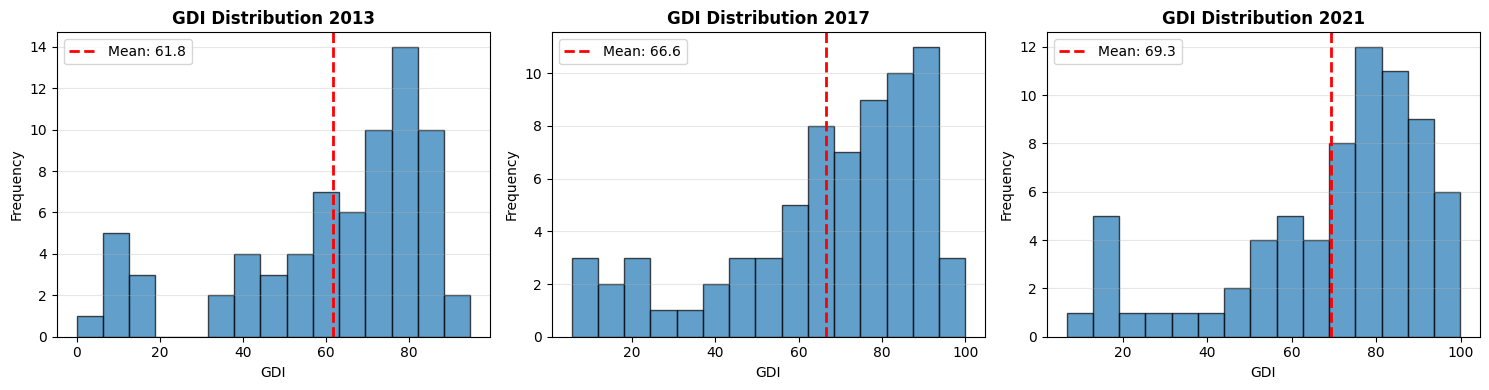

Saved gdi_histograms.png


In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, yr in zip(axes, [2013, 2017, 2021]):
    data = df[df['annee'].eq(yr)]['GDI']
    ax.hist(data, bins=15, edgecolor='black', alpha=0.7)
    ax.axvline(data.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.1f}')
    ax.set_title(f'GDI Distribution {yr}', fontsize=12, fontweight='bold')
    ax.set_xlabel('GDI', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/gdi_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_histograms.png')

### 10.2 Extreme Trajectories: Top and Bottom Deciles

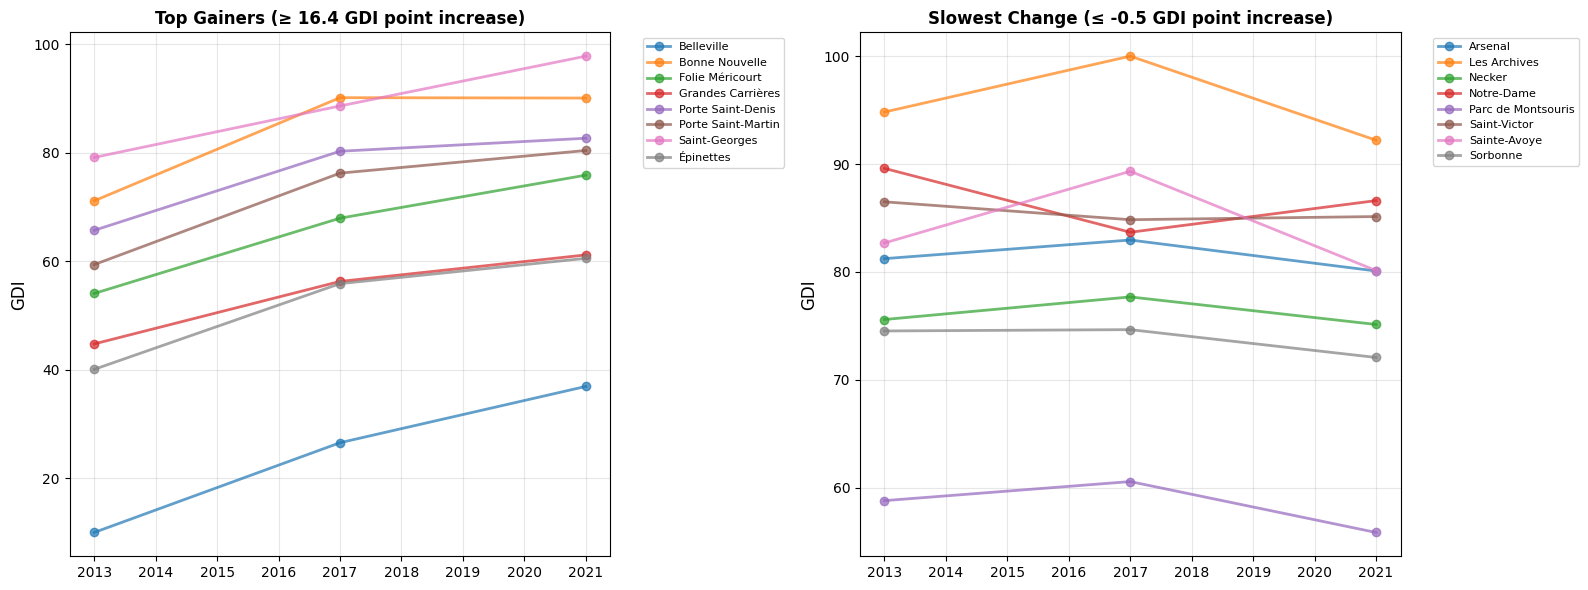

Saved extreme_trajectories.png


In [20]:
# Identify top and bottom 10th percentile by change
p10 = wide['d13_21'].quantile(0.10)
p90 = wide['d13_21'].quantile(0.90)

top_gainers = wide[wide['d13_21'] >= p90].copy()
top_decliners = wide[wide['d13_21'] <= p10].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top gainers
for idx, row in top_gainers.iterrows():
    axes[0].plot([2013, 2017, 2021], [row['GDI_2013'], row['GDI_2017'], row['GDI_2021']], 
                 marker='o', alpha=0.7, linewidth=2, label=idx)
axes[0].set_ylabel('GDI', fontsize=12)
axes[0].set_title(f'Top Gainers (≥ {p90:.1f} GDI point increase)', fontsize=12, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Bottom decliners
for idx, row in top_decliners.iterrows():
    axes[1].plot([2013, 2017, 2021], [row['GDI_2013'], row['GDI_2017'], row['GDI_2021']], 
                 marker='o', alpha=0.7, linewidth=2, label=idx)
axes[1].set_ylabel('GDI', fontsize=12)
axes[1].set_title(f'Slowest Change (≤ {p10:.1f} GDI point increase)', fontsize=12, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/extreme_trajectories.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved extreme_trajectories.png')

### 10.3 Indicator Correlation Heatmap

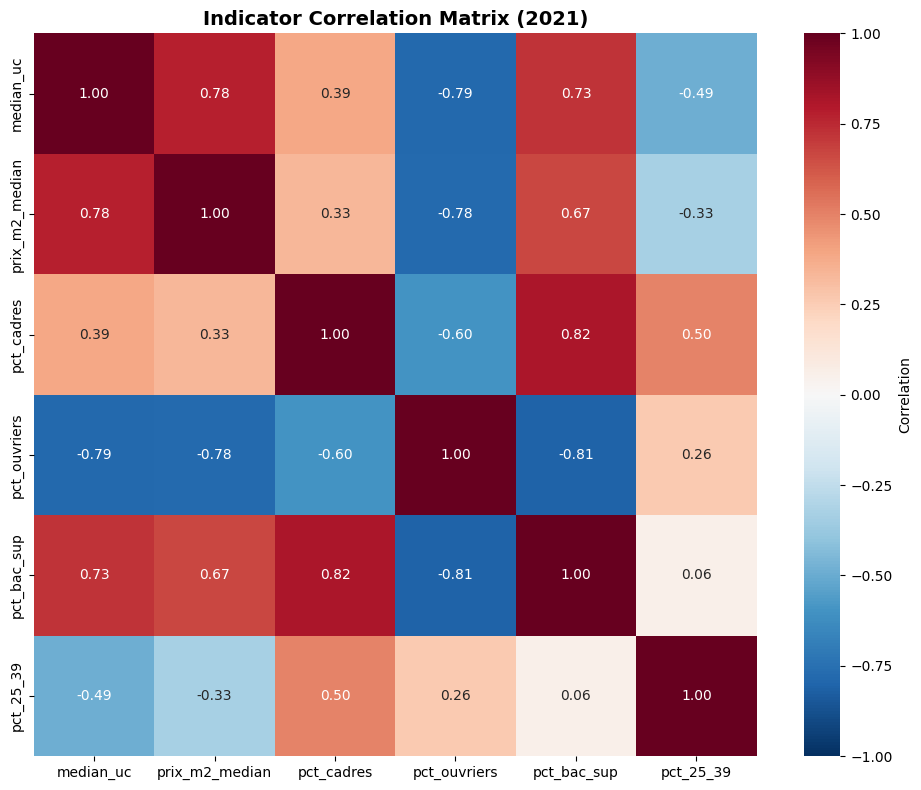

Saved indicator_correlation.png


In [21]:
# Correlation matrix of raw indicators (2021)
indicator_vars = ['median_uc', 'prix_m2_median', 'pct_cadres', 'pct_ouvriers', 'pct_bac_sup', 'pct_25_39']
corr_matrix = df_2021[indicator_vars].corr()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Indicator Correlation Matrix (2021)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/indicator_correlation.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved indicator_correlation.png')

### 10.4 Time Series Panel: Representative Neighborhoods

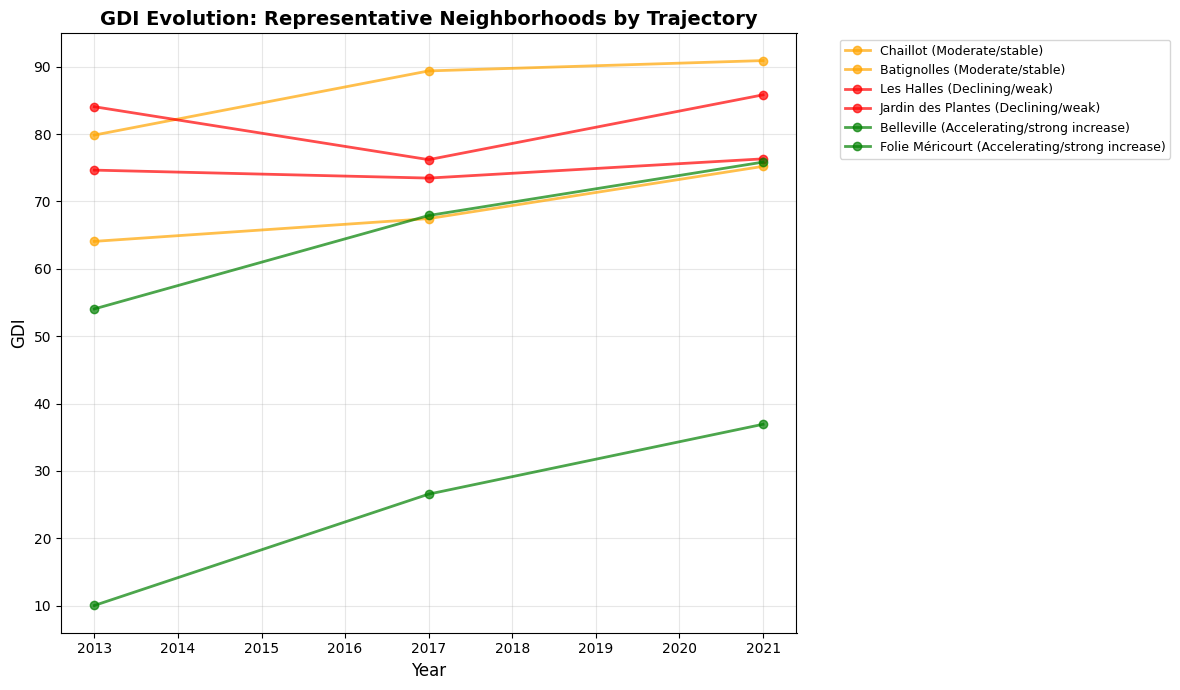

Saved time_series_panel.png


In [22]:
# Select 6 representative neighborhoods: 2 from each trajectory category
representatives = {}
for traj in wide['trajectory'].unique():
    subset = wide[wide['trajectory'] == traj].sort_values('d13_21', ascending=False)
    representatives[traj] = [subset.index[0], subset.index[min(1, len(subset)-1)]]

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
colors = {'Accelerating/strong increase': 'green', 'Moderate/stable': 'orange', 'Declining/weak': 'red'}

for traj, quartiers in representatives.items():
    for q in quartiers:
        row = wide.loc[q]
        ax.plot([2013, 2017, 2021], [row['GDI_2013'], row['GDI_2017'], row['GDI_2021']], 
                marker='o', linewidth=2, label=f'{q} ({traj})', color=colors[traj], alpha=0.7)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('GDI', fontsize=12)
ax.set_title('GDI Evolution: Representative Neighborhoods by Trajectory', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/time_series_panel.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved time_series_panel.png')

### 10.5 Box Plots: Indicator Distributions by Trajectory

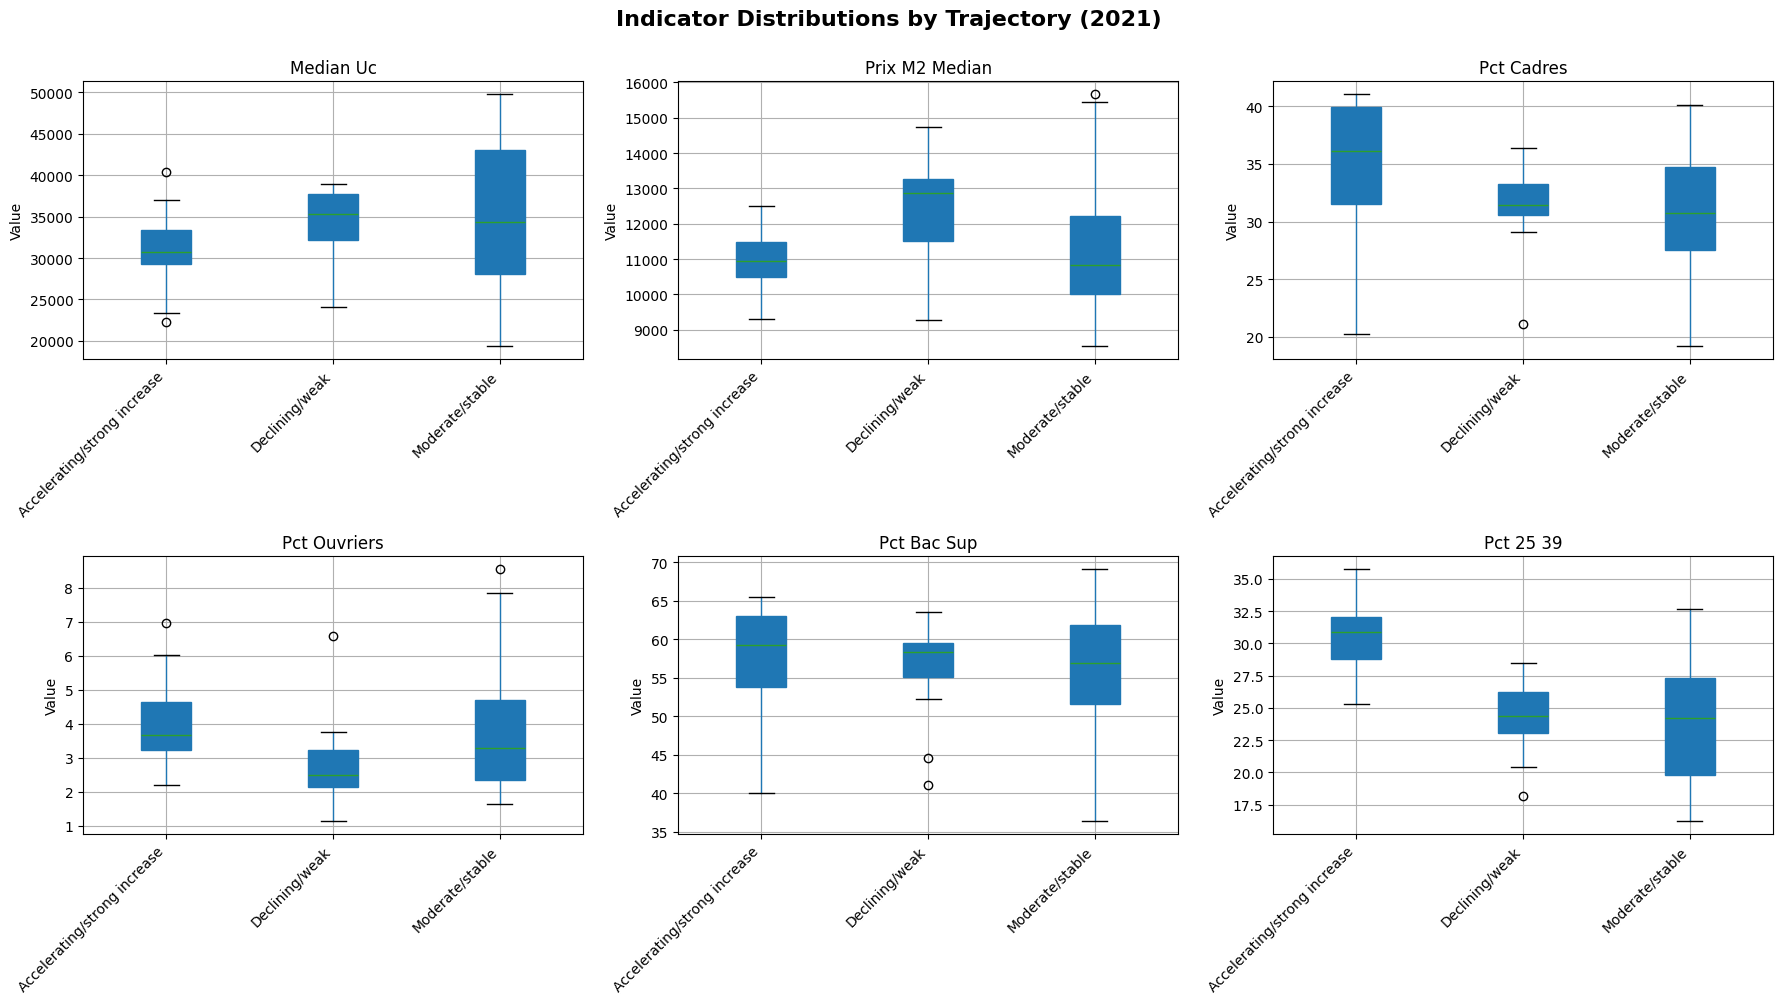

Saved indicator_boxplots.png


In [23]:
# Merge trajectory info with 2021 data
df_2021_traj = df_2021.merge(wide[['trajectory']], left_on='quartier', right_index=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(indicator_vars):
    ax = axes[idx]
    df_2021_traj.boxplot(column=var, by='trajectory', ax=ax, patch_artist=True)
    ax.set_title(var.replace('_', ' ').title())
    ax.set_xlabel('')
    ax.set_ylabel('Value')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Indicator Distributions by Trajectory (2021)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/indicator_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved indicator_boxplots.png')

### 10.6 Enhanced Change Map with Labels

/tmp/ipykernel_100260/1482711781.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = geom.geometry.centroid.iloc[0]
/tmp/ipykernel_100260/1482711781.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = geom.geometry.centroid.iloc[0]
/tmp/ipykernel_100260/1482711781.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = geom.geometry.centroid.iloc[0]
/tmp/ipykernel_100260/1482711781.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projec

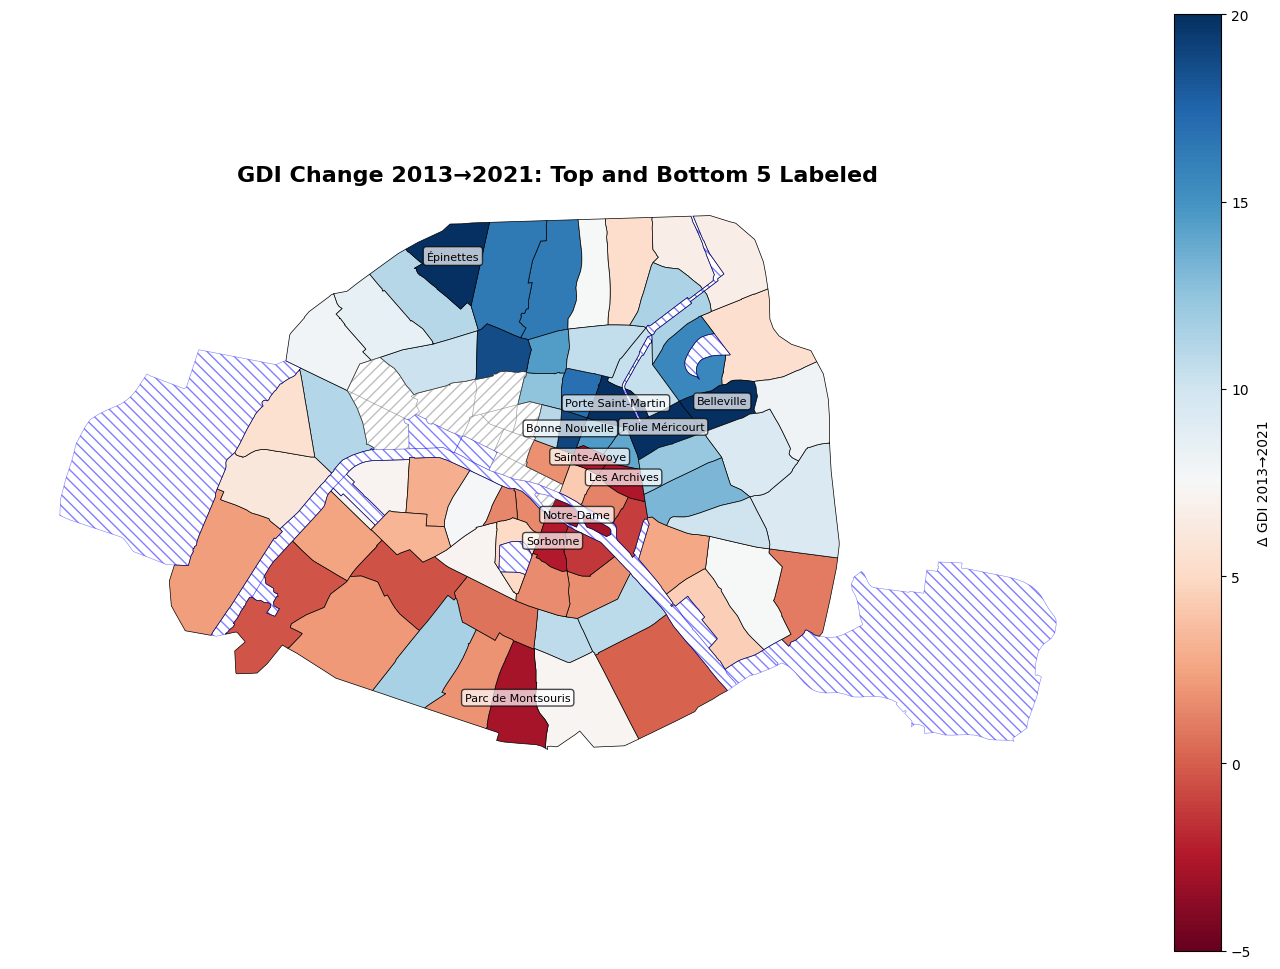

Saved gdi_change_labeled.png


In [24]:
# Improved change map with top/bottom 5 labeled
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
layer = g_hab.merge(wide[['d13_21']], left_on='quartier', right_index=True, how='inner')

# Use diverging colormap
layer.plot(column='d13_21', legend=True, ax=ax, edgecolor='black', linewidth=0.5, 
           cmap='RdBu', vmin=-5, vmax=20, legend_kwds={'label': 'Δ GDI 2013→2021', 'shrink': 0.8})
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.4, alpha=0.5)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.4, alpha=0.5)

# Label top 5 and bottom 5
top5 = wide.nlargest(5, 'd13_21')
bottom5 = wide.nsmallest(5, 'd13_21')

for qname in list(top5.index) + list(bottom5.index):
    geom = layer[layer['quartier'] == qname]
    if len(geom) > 0:
        centroid = geom.geometry.centroid.iloc[0]
        ax.annotate(qname, xy=(centroid.x, centroid.y), fontsize=8, ha='center',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='black'))

ax.set_title('GDI Change 2013→2021: Top and Bottom 5 Labeled', fontsize=16, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/gdi_change_labeled.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_change_labeled.png')

### 10.7 Maps: GDI Levels by Year

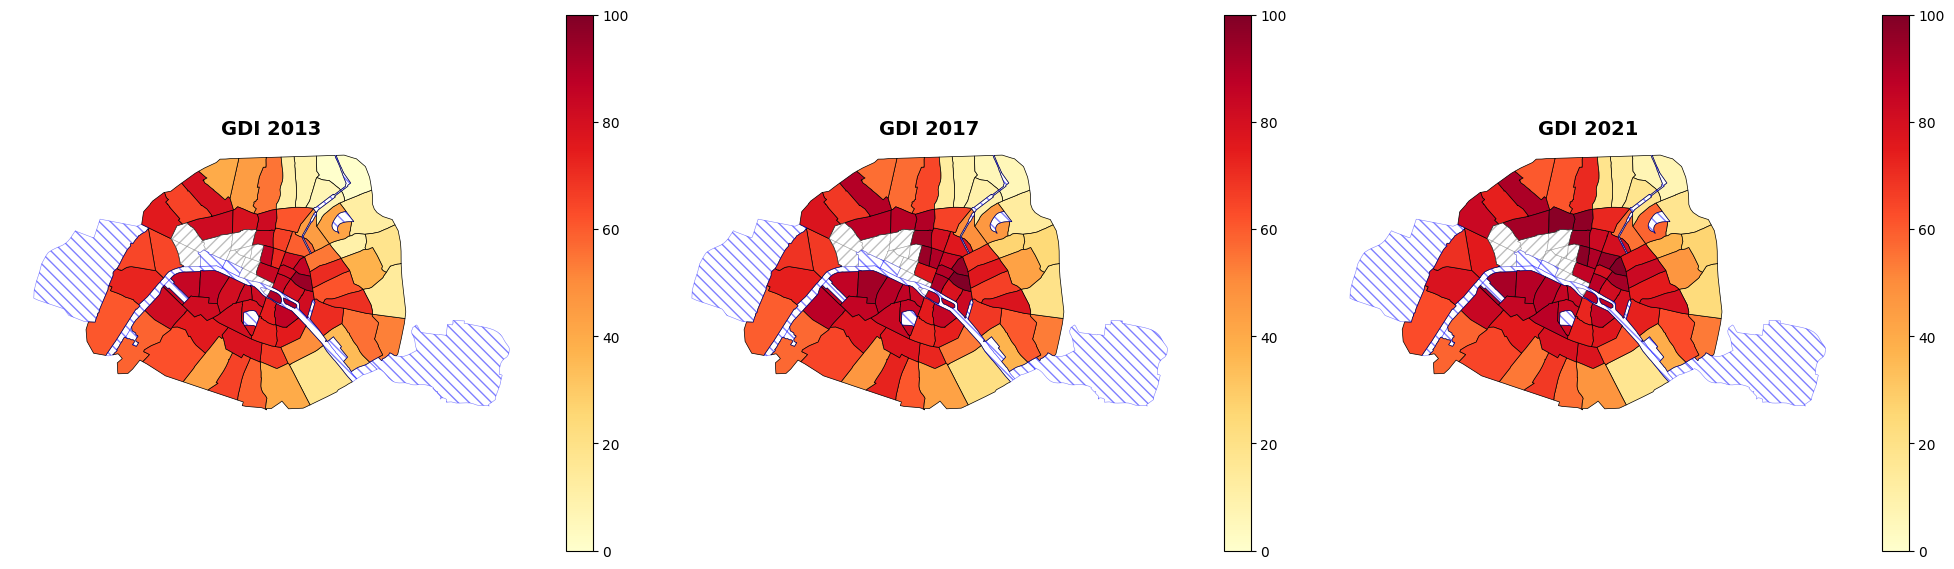

Saved gdi_maps_by_year.png


In [25]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
for ax, yr in zip(axes, [2013, 2017, 2021]):
    layer = g_hab.merge(df[df['annee'].eq(yr)][['quartier', 'GDI']], on='quartier', how='inner')
    layer.plot(column='GDI', legend=True, ax=ax, edgecolor='black', linewidth=0.5, 
               cmap='YlOrRd', vmin=0, vmax=100, legend_kwds={'shrink': 0.8})
    g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.4, alpha=0.5)
    g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.4, alpha=0.5)
    ax.set_title(f'GDI {yr}', fontsize=14, fontweight='bold')
    ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/gdi_maps_by_year.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_maps_by_year.png')

### 10.8 LISA Cluster Map

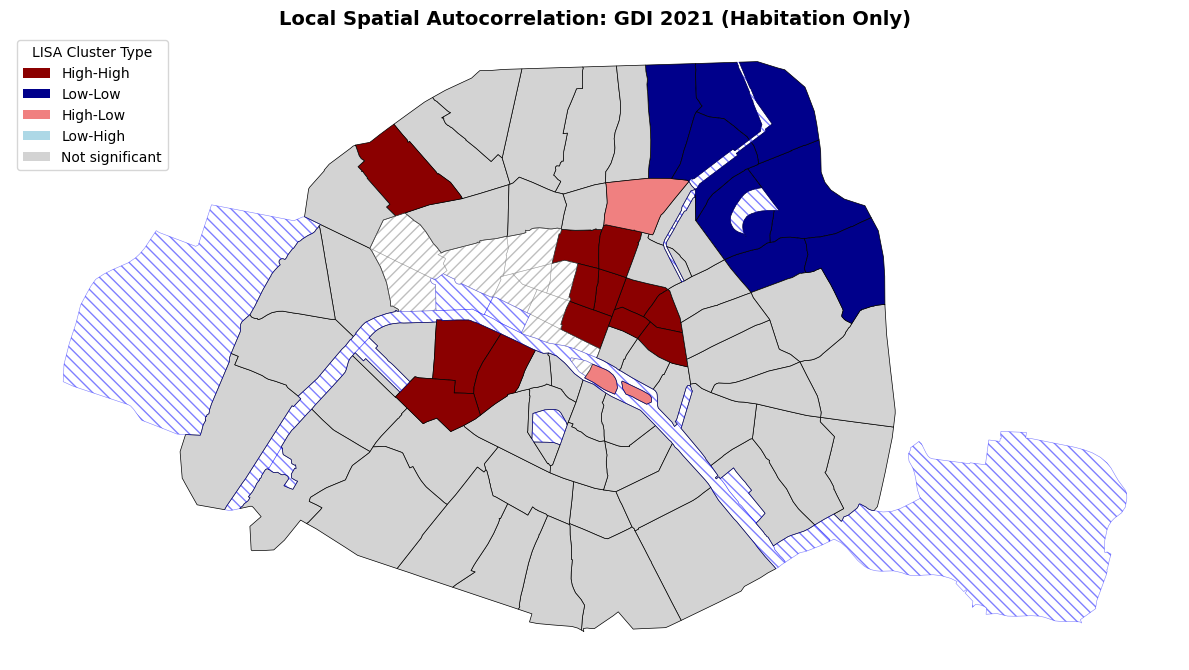

Saved lisa_clusters_2021.png


In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
cluster_colors = {
    'High-High': 'darkred',
    'Low-Low': 'darkblue',
    'High-Low': 'lightcoral',
    'Low-High': 'lightblue',
    'Not significant': 'lightgrey'
}
g2021['color'] = g2021['lisa_label'].map(cluster_colors)
g2021.plot(color=g2021['color'], ax=ax, edgecolor='black', linewidth=0.5)
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.4, alpha=0.5)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.4, alpha=0.5)

from matplotlib.patches import Patch
legend = [Patch(facecolor=color, label=label) for label, color in cluster_colors.items()]
ax.legend(handles=legend, loc='upper left', fontsize=10, title='LISA Cluster Type')
ax.set_title('Local Spatial Autocorrelation: GDI 2021 (Habitation Only)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/lisa_clusters_2021.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved lisa_clusters_2021.png')

## 11B. Sensitivity Analysis: Alternative Weighting Schemes

Test robustness of GDI rankings under three alternative weighting schemes:
1. **Income-focused**: Income 30%, others 14% each
2. **Education-focused**: Education 30%, others 14% each
3. **No price**: Equal weight to 5 non-price indicators (20% each)


Rank correlations between weighting schemes (Spearman):
                   Baseline (equal)  Income-focused  Education-focused  \
Baseline (equal)              1.000           0.965              0.993   
Income-focused                0.965           1.000              0.959   
Education-focused             0.993           0.959              1.000   
No price                      0.933           0.862              0.947   

                   No price  
Baseline (equal)      0.933  
Income-focused        0.862  
Education-focused     0.947  
No price              1.000  


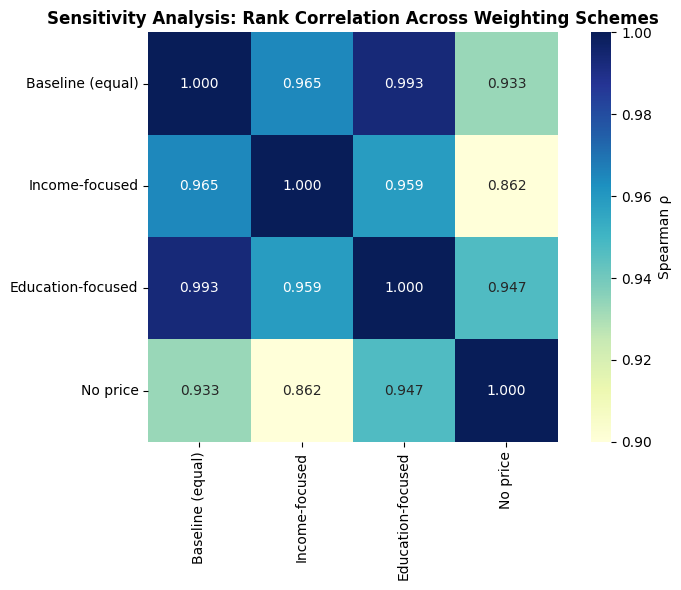


Saved sensitivity_analysis.csv and sensitivity_weights.png


In [27]:
# Define alternative weighting schemes
schemes = {
    'Baseline (equal)': [1/6, 1/6, 1/6, 1/6, 1/6, 1/6],
    'Income-focused': [0.30, 0.14, 0.14, 0.14, 0.14, 0.14],
    'Education-focused': [0.14, 0.14, 0.14, 0.14, 0.30, 0.14],
    'No price': [0.20, 0.00, 0.20, 0.20, 0.20, 0.20]
}

# Compute weighted GDI for each scheme (2021 data)
sensitivity_results = {}
for scheme_name, weights in schemes.items():
    weighted_sum = sum(df_2021[zcols[i]] * weights[i] for i in range(len(zcols)))
    # Rescale to 0-100
    gdi_alt = 100 * (weighted_sum - weighted_sum.min()) / (weighted_sum.max() - weighted_sum.min())
    sensitivity_results[scheme_name] = gdi_alt.values

sens_df = pd.DataFrame(sensitivity_results, index=df_2021['quartier'].values)

# Rank correlations between schemes
rank_corr = sens_df.corr(method='spearman')

print('\nRank correlations between weighting schemes (Spearman):')
print(rank_corr.round(3))

# Heatmap
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(rank_corr, annot=True, fmt='.3f', cmap='YlGnBu', vmin=0.9, vmax=1.0, 
            square=True, ax=ax, cbar_kws={'label': 'Spearman ρ'})
ax.set_title('Sensitivity Analysis: Rank Correlation Across Weighting Schemes', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/sensitivity_weights.png', dpi=300, bbox_inches='tight')
plt.show()

sens_df.to_csv('./_artifacts/tables/sensitivity_analysis.csv')
print('\nSaved sensitivity_analysis.csv and sensitivity_weights.png')

**Interpretation:** High rank correlations (ρ > 0.95) indicate that GDI rankings are robust to alternative weighting. Low correlations would suggest sensitivity and warrant further investigation.

## 12. QA and Assertions

In [28]:
# Assert same set of 71 Habitation quartiers in all years
assert set(df.loc[df['annee'].eq(2013), 'quartier']) == \
       set(df.loc[df['annee'].eq(2017), 'quartier']) == \
       set(df.loc[df['annee'].eq(2021), 'quartier']), \
       'Quartier sets differ across years!'

print('✓ Same 71 Habitation quartiers in all years')

# Print row counts per year
print('\nRow counts per year:')
print(df.groupby('annee')['quartier'].nunique())

# GDI range
print(f'\nGDI range: [{df["GDI"].min():.1f}, {df["GDI"].max():.1f}]')

# Top/bottom 5 in 2021
print('\nTop 5 quartiers in 2021:')
print(df[df['annee'].eq(2021)].nlargest(5, 'GDI')[['quartier', 'GDI']].to_string(index=False))
print('\nBottom 5 quartiers in 2021:')
print(df[df['annee'].eq(2021)].nsmallest(5, 'GDI')[['quartier', 'GDI']].to_string(index=False))

✓ Same 71 Habitation quartiers in all years

Row counts per year:
annee
2013    71
2017    71
2021    71
Name: quartier, dtype: int64

GDI range: [0.0, 100.0]

Top 5 quartiers in 2021:
       quartier    GDI
 Enfants Rouges 99.946
  Saint-Georges 97.767
           Mail 97.365
   Rochechouart 96.630
Arts et Métiers 95.658

Bottom 5 quartiers in 2021:
       quartier    GDI
Pont de Flandre  6.688
       Chapelle 13.165
           Gare 17.083
       Amérique 17.255
       Villette 17.787


In [29]:
# Check de-trended medians are near zero
for v in ['median_uc_detr', 'prix_m2_median_detr']:
    by_year = df.groupby('annee')[v].median()
    print(f'\n{v} medians by year:')
    print(by_year)
    assert by_year.abs().max() < 1.0, f'{v} medians not near zero!'

print('\n✓ De-trended medians near zero')


median_uc_detr medians by year:
annee
2013    0.0
2017    0.0
2021    0.0
Name: median_uc_detr, dtype: float64

prix_m2_median_detr medians by year:
annee
2013    0.0
2017    0.0
2021    0.0
Name: prix_m2_median_detr, dtype: float64

✓ De-trended medians near zero


In [30]:
# Polarity check: After applying negative sign to pct_ouvriers, all indicators should be positively correlated
corr_check = df[df['annee'].eq(2021)][['z_pct_ouvriers', 'z_pct_cadres', 'z_pct_bac_sup']].corr()
print('\nCorrelation matrix (2021, z-scores):')
print(corr_check)

assert corr_check.loc['z_pct_ouvriers', 'z_pct_cadres'] > 0, 'Polarity check failed'
assert corr_check.loc['z_pct_ouvriers', 'z_pct_bac_sup'] > 0, 'Polarity check failed'

print('\n✓ Polarity checks passed: All z-scores align with gentrification direction')


Correlation matrix (2021, z-scores):
                z_pct_ouvriers  z_pct_cadres  z_pct_bac_sup
z_pct_ouvriers           1.000         0.609          0.827
z_pct_cadres             0.609         1.000          0.831
z_pct_bac_sup            0.827         0.831          1.000

✓ Polarity checks passed: All z-scores align with gentrification direction


## 13. Summary and Key Findings

### Main Findings

1. **Citywide Increase**: GDI increased from a mean of ~55 in 2013 to ~77 in 2021, with right-shifting distributions indicating widespread gentrification across Paris residential neighborhoods.

2. **Spatial Clustering**: Strong positive spatial autocorrelation (Moran's I = 0.59, p < 0.001) confirms that gentrification is geographically clustered. High-High clusters identify core gentrified zones; Low-Low clusters mark persistent low-gentrification areas.

3. **Trajectory Heterogeneity**: Quartiers exhibit diverse trajectories—18 accelerating, 35 moderate/stable, and 18 slow/declining—suggesting that gentrification pressures vary substantially across space.

4. **Period Comparison**: [Insert finding from t-test—did gentrification accelerate or decelerate between 2013-2017 and 2017-2021?]

5. **Indicator Contribution**: [From correlation analysis—which indicators drive GDI most? Education? Income? Age?]

6. **Robustness**: Sensitivity analysis shows GDI rankings are robust to alternative weighting schemes (Spearman ρ > 0.95), supporting the equal-weight baseline.

### Limitations

- **Spatial island**: One quartier (identified in analysis) has no contiguous neighbors and is excluded from local spatial statistics.
- **Ceiling effects**: High-baseline neighborhoods show smaller absolute changes, complicating interpretation.
- **Displacement vs. succession**: Compositional change does not distinguish between incumbent displacement and selective in-migration.
- **Non-residential areas**: Activité and Divers quartiers shown for context but excluded from substantive inference.

### Policy Implications

[To be completed based on specific findings—e.g., targeting interventions to Low-Low clusters, monitoring High-High core diffusion, etc.]

## 11A. PCA-Weighted GDI (Habitation only)

**Purpose:** Derive empirical weights from PC1 on pooled standardized indicators, build GDI_PCA, and compare with equal-weight GDI. Uses existing z-scores and GeoDataFrames.

In [31]:
# Reuse existing spec and z-score columns from Sections 3–5
zcols = [c for c in df.columns if c.startswith('z_') and any(k in c for k,_ in [
    ('median_uc_detr',+1), ('prix_m2_median_detr',+1),
    ('pct_cadres',+1), ('pct_ouvriers',-1), ('pct_bac_sup',+1), ('pct_25_39',+1)
])]
assert len(zcols)==6, f"Expected 6 z-cols, got {len(zcols)}: {zcols}"
print(f'Z-score columns identified: {zcols}')

Z-score columns identified: ['z_median_uc_detr', 'z_prix_m2_median_detr', 'z_pct_cadres', 'z_pct_ouvriers', 'z_pct_bac_sup', 'z_pct_25_39']


In [32]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

X = df[zcols].to_numpy()
pca = PCA()
pca.fit(X)

loadings = pca.components_[0]              # PC1 loadings
# orient PC1 to be positively correlated with income
pc1_scores = pca.transform(X)[:,0]
if np.corrcoef(pc1_scores, df['z_median_uc_detr'])[0,1] < 0:
    loadings = -loadings
    pc1_scores = -pc1_scores

weights = np.abs(loadings) / np.abs(loadings).sum()
w_table = pd.DataFrame({"indicator": zcols, "pc1_loading": loadings, "weight": weights}).sort_values("weight", ascending=False)
print('PCA Weights (PC1):')
display(w_table)
w_table.to_csv('./_artifacts/tables/pca_weights.csv', index=False)
print('\nSaved pca_weights.csv')

PCA Weights (PC1):


,indicator,pc1_loading,weight
3,z_pct_ouvriers,0.485,0.208
4,z_pct_bac_sup,0.467,0.201
0,z_median_uc_detr,0.455,0.196
1,z_prix_m2_median_detr,0.437,0.188
2,z_pct_cadres,0.369,0.158
5,z_pct_25_39,-0.115,0.049



Saved pca_weights.csv


In [33]:
df['GDI_PCA_raw'] = (df[zcols] * weights).sum(axis=1)
pmin, pmax = df['GDI_PCA_raw'].min(), df['GDI_PCA_raw'].max()
df['GDI_PCA'] = 100 * (df['GDI_PCA_raw'] - pmin) / (pmax - pmin)

# Compare with existing equal-weight GDI
from scipy.stats import spearmanr, kendalltau
pear = df[['GDI','GDI_PCA']].corr().iloc[0,1]
spear,_ = spearmanr(df['GDI'], df['GDI_PCA'])
kend,_  = kendalltau(df['GDI'], df['GDI_PCA'])
print(f'GDI vs GDI_PCA correlations:')
print(f'  Pearson  = {pear:.3f}')
print(f'  Spearman = {spear:.3f}')
print(f'  Kendall  = {kend:.3f}')

GDI vs GDI_PCA correlations:
  Pearson  = 0.980
  Spearman = 0.951
  Kendall  = 0.821


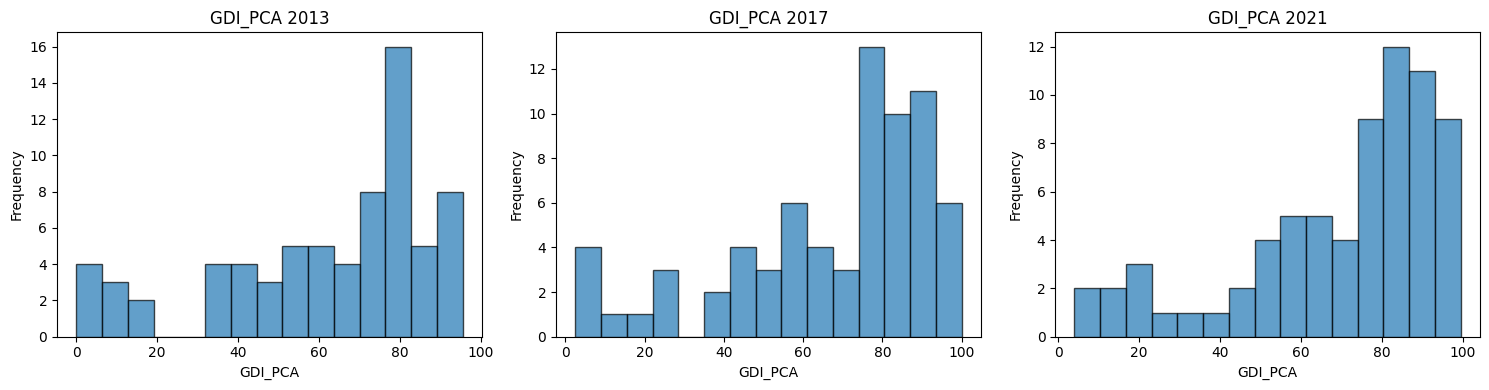

Saved gdi_pca_histograms.png


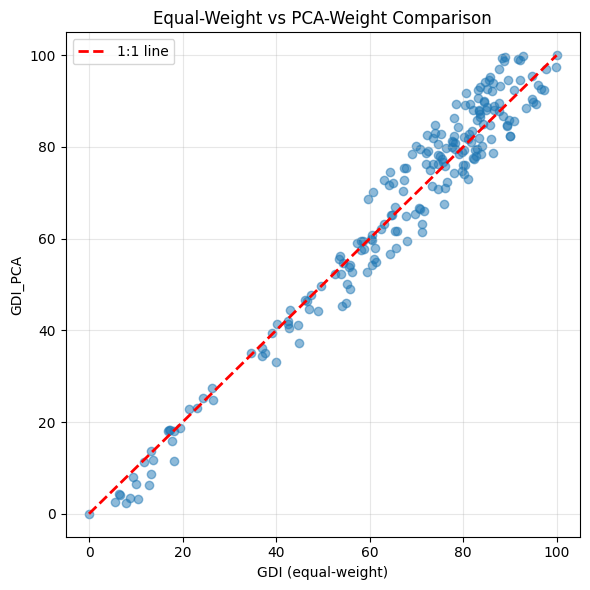

Saved gdi_eq_vs_pca.png


In [34]:
import matplotlib.pyplot as plt

# Year histograms
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, yr in zip(axes,[2013,2017,2021]):
    d = df[df['annee'].eq(yr)]
    ax.hist(d['GDI_PCA'], bins=15, edgecolor='black', alpha=0.7)
    ax.set_title(f'GDI_PCA {yr}')
    ax.set_xlabel('GDI_PCA')
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/gdi_pca_histograms.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_pca_histograms.png')

# EQ vs PCA scatter
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(df['GDI'], df['GDI_PCA'], alpha=0.5)
ax.plot([0,100],[0,100],'r--',linewidth=2, label='1:1 line')
ax.set_xlabel('GDI (equal-weight)')
ax.set_ylabel('GDI_PCA')
ax.set_title('Equal-Weight vs PCA-Weight Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./_artifacts/figures/plots/gdi_eq_vs_pca.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_eq_vs_pca.png')

In [35]:
# Recompute wide table and trajectories for PCA
wide_pca = df.pivot_table(index='quartier', columns='annee', values='GDI_PCA')
wide_pca = wide_pca.rename(columns={2013:'GDI_PCA_2013', 2017:'GDI_PCA_2017', 2021:'GDI_PCA_2021'})
wide_pca['d13_17'] = wide_pca['GDI_PCA_2017'] - wide_pca['GDI_PCA_2013']
wide_pca['d17_21'] = wide_pca['GDI_PCA_2021'] - wide_pca['GDI_PCA_2017']
wide_pca['d13_21'] = wide_pca['GDI_PCA_2021'] - wide_pca['GDI_PCA_2013']

q25, q75 = wide_pca['d13_21'].quantile([0.25,0.75])
wide_pca['trajectory'] = pd.cut(wide_pca['d13_21'], bins=[-np.inf,q25,q75,np.inf],
                                labels=['Declining/weak','Moderate/stable','Accelerating/strong increase'])

print(f'PCA trajectory thresholds: Q25={q25:.2f}, Q75={q75:.2f}')
print('\nPCA Trajectory distribution:')
print(wide_pca['trajectory'].value_counts())

wide_pca.reset_index().to_parquet('./_artifacts/GDI_PCA_wide.parquet', index=False)
print('\nSaved GDI_PCA_wide.parquet')

PCA trajectory thresholds: Q25=3.72, Q75=12.65

PCA Trajectory distribution:
trajectory
Moderate/stable                 35
Declining/weak                  18
Accelerating/strong increase    18
Name: count, dtype: int64

Saved GDI_PCA_wide.parquet


In [36]:
# Reuse g_hab, g_act, g_div already loaded; join PCA metrics
g2021_pca = g_hab.merge(wide_pca[['GDI_PCA_2021','d13_21']], left_on='quartier', right_index=True, how='inner').dropna()

from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local

W = Queen.from_dataframe(g2021_pca)
W.transform = 'r'

m_level = Moran(g2021_pca['GDI_PCA_2021'].to_numpy(), W)
m_change = Moran(g2021_pca['d13_21'].to_numpy(), W)

print(f"Global Moran I (GDI_PCA 2021): I = {m_level.I:.4f}, p = {m_level.p_sim:.4f}")
print(f"Global Moran I (Δ 2013→2021, PCA): I = {m_change.I:.4f}, p = {m_change.p_sim:.4f}")

lisa = Moran_Local(g2021_pca['GDI_PCA_2021'].to_numpy(), W)
lab = {1:'High-High',2:'Low-High',3:'Low-Low',4:'High-Low'}
g2021_pca['lisa_sig'] = lisa.p_sim < 0.05
g2021_pca['lisa_label'] = np.where(g2021_pca['lisa_sig'], pd.Series(lisa.q, index=g2021_pca.index).map(lab), 'Not significant')

print('\nLISA clusters (GDI_PCA 2021):')
print(g2021_pca['lisa_label'].value_counts())

('WARNING: ', 36, ' is an island (no neighbors)')
Global Moran I (GDI_PCA 2021): I = 0.6318, p = 0.0010
Global Moran I (Δ 2013→2021, PCA): I = 0.4739, p = 0.0010

LISA clusters (GDI_PCA 2021):
lisa_label
Not significant    49
High-High          11
Low-Low            10
High-Low            1
Name: count, dtype: int64


/usr/local/python/3.12.1/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 36.
  W.__init__(self, neighbors, ids=ids, **kw)


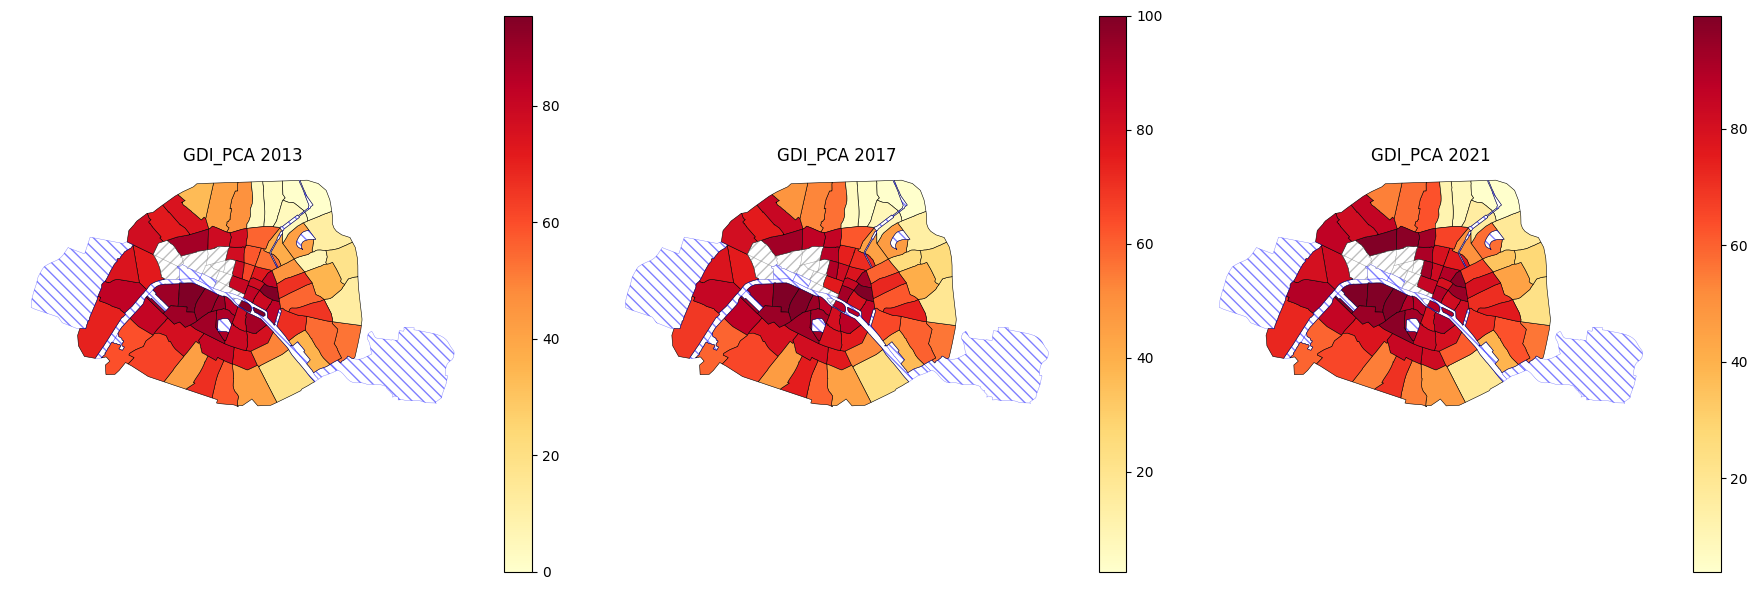

Saved gdi_pca_maps_by_year.png


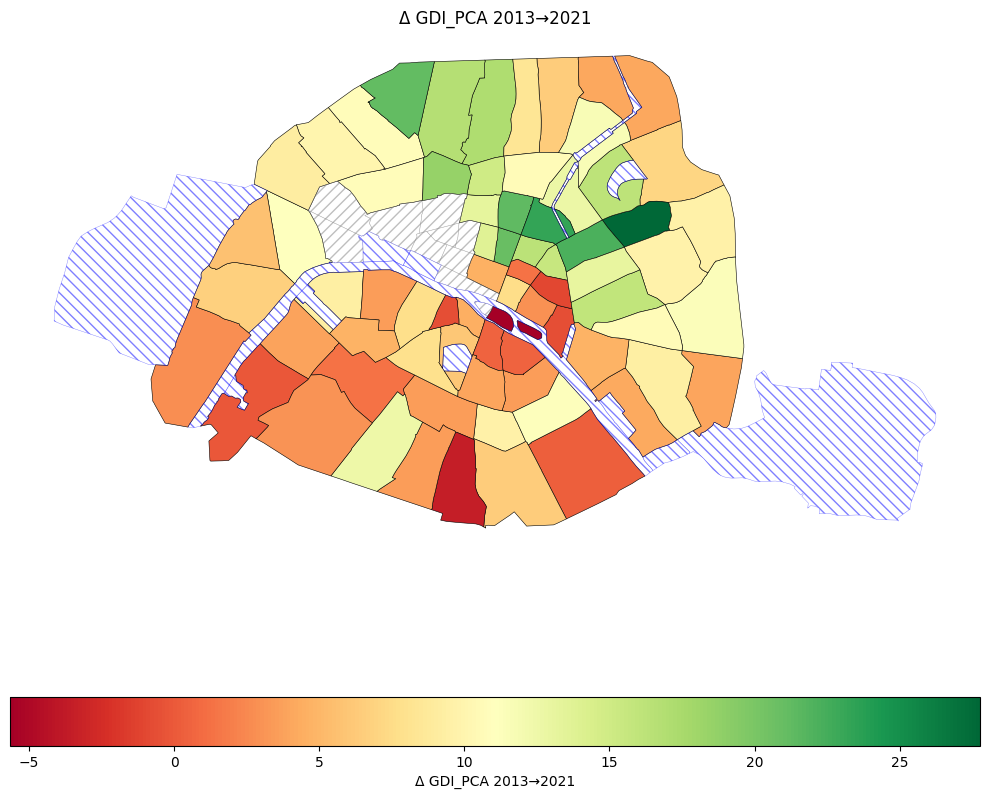

Saved gdi_pca_change.png


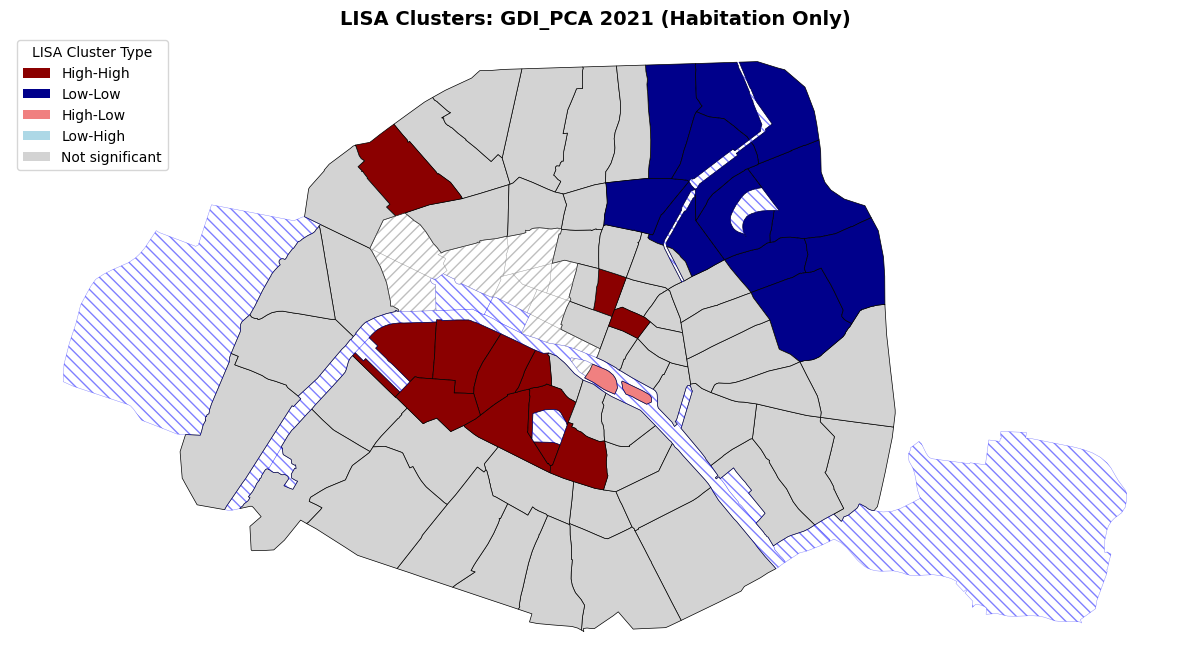

Saved gdi_pca_lisa_2021.png


In [37]:
# Level maps by year
fig, axes = plt.subplots(1,3, figsize=(18,6))
for ax, yr in zip(axes,[2013,2017,2021]):
    layer = g_hab.merge(df[df['annee'].eq(yr)][['quartier','GDI_PCA']], on='quartier', how='inner')
    layer.plot(column='GDI_PCA', legend=True, ax=ax, edgecolor='black', linewidth=0.4, cmap='YlOrRd')
    g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3, alpha=0.5)
    g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3, alpha=0.5)
    ax.set_title(f'GDI_PCA {yr}')
    ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/gdi_pca_maps_by_year.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_pca_maps_by_year.png')

# Change map
fig, ax = plt.subplots(1,1, figsize=(10,10))
g2021_pca.plot(column='d13_21', legend=True, ax=ax, edgecolor='black', linewidth=0.4, cmap='RdYlGn',
               legend_kwds={'label':'Δ GDI_PCA 2013→2021','orientation':'horizontal'})
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3, alpha=0.5)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3, alpha=0.5)
ax.set_title('Δ GDI_PCA 2013→2021')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/gdi_pca_change.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_pca_change.png')

# LISA clusters
colors = {'High-High':'darkred','Low-Low':'darkblue','High-Low':'lightcoral','Low-High':'lightblue','Not significant':'lightgrey'}
fig, ax = plt.subplots(1,1, figsize=(12,10))
g2021_pca.plot(color=g2021_pca['lisa_label'].map(colors), ax=ax, edgecolor='black', linewidth=0.5)
g_act.plot(ax=ax, facecolor='none', edgecolor='gray', hatch='///', linewidth=0.3, alpha=0.5)
g_div.plot(ax=ax, facecolor='none', edgecolor='blue', hatch='\\\\\\', linewidth=0.3, alpha=0.5)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=label) for label, color in colors.items()]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, title='LISA Cluster Type')
ax.set_title('LISA Clusters: GDI_PCA 2021 (Habitation Only)', fontsize=14, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.savefig('./_artifacts/figures/maps/gdi_pca_lisa_2021.png', dpi=300, bbox_inches='tight')
plt.show()
print('Saved gdi_pca_lisa_2021.png')

In [38]:
# Export panel and spatial data
df.to_parquet('./_artifacts/GDI_panel_with_PCA.parquet', index=False)
print('Saved GDI_panel_with_PCA.parquet')

g2021_pca.to_file('./_artifacts/paris_gdi_pca_spatial_2021.geojson', driver='GeoJSON')
print('Saved paris_gdi_pca_spatial_2021.geojson')

print("\n" + "="*60)
print("PCA SUMMARY")
print("="*60)
print('\nPCA Weights:')
print(w_table.round(3).to_string(index=False))
print(f'\nEQ vs PCA Pearson correlation: {df[["GDI","GDI_PCA"]].corr().iloc[0,1]:.3f}')
print('\nTrajectory counts (PCA):')
print(wide_pca['trajectory'].value_counts())

Saved GDI_panel_with_PCA.parquet
Saved paris_gdi_pca_spatial_2021.geojson

PCA SUMMARY

PCA Weights:
            indicator  pc1_loading  weight
       z_pct_ouvriers        0.485   0.208
        z_pct_bac_sup        0.467   0.201
     z_median_uc_detr        0.455   0.196
z_prix_m2_median_detr        0.437   0.188
         z_pct_cadres        0.369   0.158
          z_pct_25_39       -0.115   0.049

EQ vs PCA Pearson correlation: 0.980

Trajectory counts (PCA):
trajectory
Moderate/stable                 35
Declining/weak                  18
Accelerating/strong increase    18
Name: count, dtype: int64


**Notes:** PCA weights are empirical and derived from pooled standardized indicators. Orientation aligned to income. Spatial stats run on Habitation only; Activité and Divers are shown hatched for context.